## Setup

In [1]:
import math
import numpy as np
import numpy as np
import dask.array as da
import time
import math

# Optional: For plotting later
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
np.random.seed(42) # Use a fixed seed for reproducibility

In [2]:

# STEP 1: Generate a synthetic 12x3 matrix and convert to Dask array with 3 blocks
A_np = np.random.randn(12, 3) # Created a 12x3 NumPy matrix

# Convert to Dask array, chunked row-wise into 3 blocks of 4x3
A = da.from_array(A_np, chunks=(4, 3))

# Print the matrix shape and block info
print("Matrix A shape:", A.shape)
print("Chunks:", A.chunks)

# Visualize the matrix
A.compute()

def kappa(A):
    """
    Computes the condition number of matrix A in 2-norm.
    """
    return np.linalg.cond(A)


print('k(A): ',kappa(A))


Matrix A shape: (12, 3)
Chunks: ((4, 4, 4), (3,))
k(A):  1.2152233096853164


/Users/mohit/anaconda3/lib/python3.11/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.linalg.cond` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


## Cholesky QR

In [3]:
from dask import delayed
import dask.array as da
import numpy as np

def cholesky_qr(A):
    # using dask and in mapreduce style
    blocks = A.to_delayed().flatten()
    chunk_sizes = A.chunks[0]
    n_cols = A.shape[1]

    # ---------------------------- MAP: Compute A_i^T A_i for each block (Gramian pieces) ----------------------------
    @delayed
    def local_gramian(block):
        return block.T @ block
    local_gramians = [local_gramian(block) for block in blocks]

    # ---------------------------- REDUCE: Sum the Gramians → G = A^T A ----------------------------
    G = delayed(lambda *grs: sum(grs))(*local_gramians)
    G_np = G.compute()

    # FLOPs: Local Gramians (each block)
    m_blocks = [int(size) for size in chunk_sizes]
    flops_gramians = sum([2 * m * n_cols**2 for m in m_blocks])  # 2mn² per block

    # ---------------------------- Cholesky decomposition: G = Rᵀ R ----------------------------
    R = np.linalg.cholesky(G_np).T

    # FLOPs: Cholesky of n x n SPD matrix: 1/3 n³
    flops_cholesky = (1 / 3) * n_cols**3

    # ---------------------------- MAP: Q_i = A_i @ R⁻¹ (apply inverse blockwise) ----------------------------
    R_inv = np.linalg.inv(R)

    flops_inverse = (1/3) * n_cols**3  # For inv(R), approx
    flops_q_blocks = sum([2 * m * n_cols**2 for m in m_blocks])  # A_i @ R⁻¹

    Q_blocks = [
        da.from_delayed(
            delayed(lambda b: b @ R_inv)(block),
            shape=(m, n_cols),
            dtype=A.dtype
        )
        for block, m in zip(blocks, m_blocks)
    ]

    Q = da.vstack(Q_blocks)

    # ---------------------------- Total FLOPs ----------------------------
    total_flops = flops_gramians + flops_cholesky + flops_inverse + flops_q_blocks

    return Q, R, total_flops
Q_chol, R_chol, flops_chol = cholesky_qr(A)

print("Q (Cholesky QR):\n", Q_chol.compute())
print("R (Cholesky QR):\n", R_chol)
print("Total FLOPs (Cholesky QR):", int(flops_chol))


Q (Cholesky QR):
 [[ 0.17  -0.034  0.209]
 [ 0.522 -0.049 -0.028]
 [ 0.541  0.241 -0.088]
 [ 0.186 -0.127 -0.129]
 [ 0.083 -0.549 -0.532]
 [-0.193 -0.299  0.069]
 [-0.311 -0.418  0.402]
 [-0.077  0.017 -0.436]
 [-0.186  0.025 -0.362]
 [ 0.129 -0.169 -0.083]
 [-0.206  0.527 -0.004]
 [-0.362  0.224 -0.392]]
R (Cholesky QR):
 [[ 2.919 -0.124 -0.279]
 [ 0.     3.468 -0.109]
 [ 0.     0.     3.313]]
Total FLOPs (Cholesky QR): 450


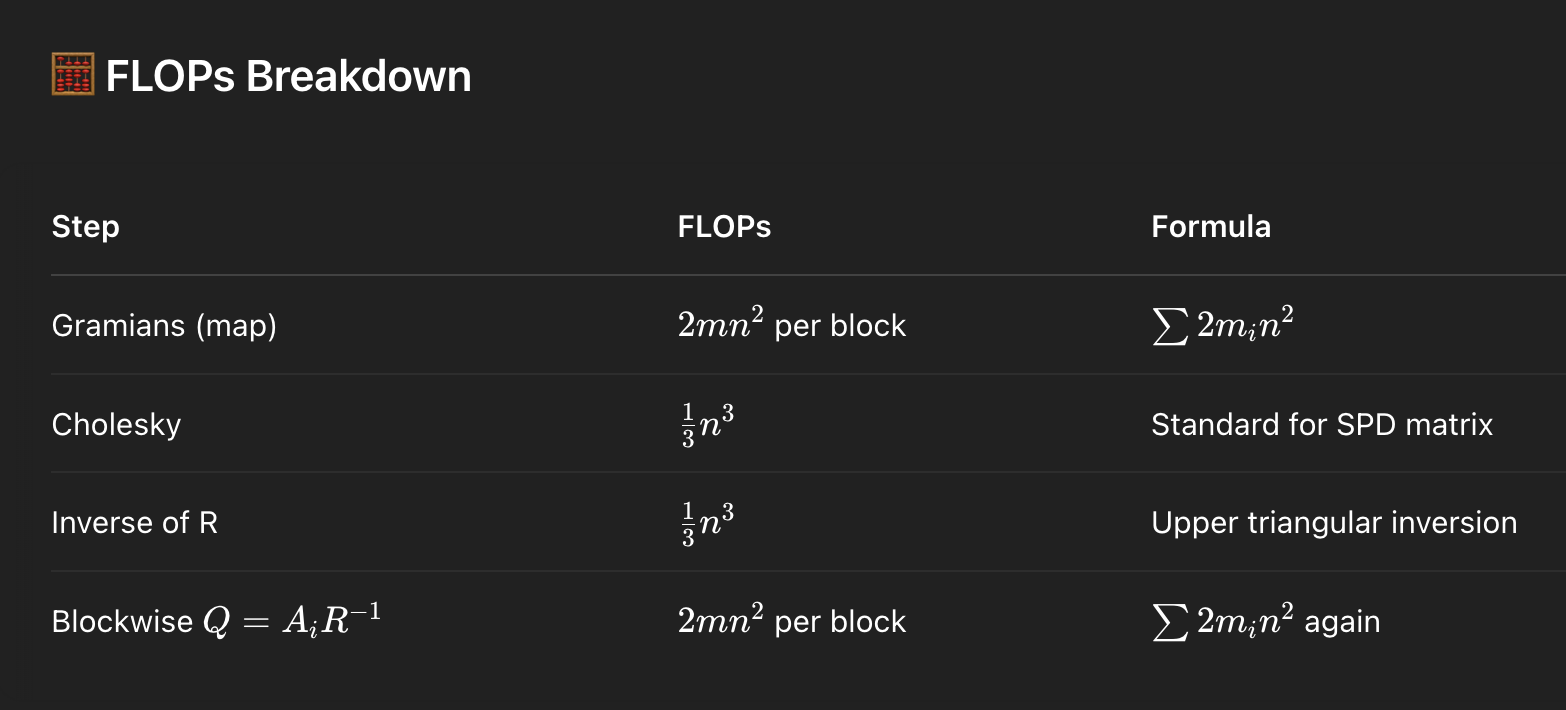


In [4]:
import numpy as np

def kappa(A):
    """
    Computes the condition number of matrix A in 2-norm.
    """
    return np.linalg.cond(A)



## Householder QR

### FLOPs Breakdown for A ∈ ℝ^{12 × 3}

#### Formula:

$$ \text{FLOPs}_{\text{Householder}} = 2mn^2 - \frac{2}{3}n^3 $$
$$ = 2 \cdot 12 \cdot 9 - \frac {2}{3} \cdot 27 $$

$$ = 216 - 18 = \boxed{198} $$

In [5]:
# STEP 5: Householder QR (centralized using NumPy)
def householder_qr(A_dask):
    # we are using numpy directly
    A_np = A_dask.compute()
    Q, R = np.linalg.qr(A_np)
    return Q, R


def householder_flops(m, n):
    return math.ceil(2*m*n*n -2*n*n*n/3)

# Run it
Q_house, R_house = householder_qr(A)

# Output
print("Q (Householder):\n", Q_house)
print("R (Householder):\n", R_house)
flops_chol = householder_flops(A.shape[0], A.shape[1])
print("Total FLOPs (Direct TSQR):", int(flops_chol))

Q (Householder):
 [[-0.17  -0.034  0.209]
 [-0.522 -0.049 -0.028]
 [-0.541  0.241 -0.088]
 [-0.186 -0.127 -0.129]
 [-0.083 -0.549 -0.532]
 [ 0.193 -0.299  0.069]
 [ 0.311 -0.418  0.402]
 [ 0.077  0.017 -0.436]
 [ 0.186  0.025 -0.362]
 [-0.129 -0.169 -0.083]
 [ 0.206  0.527 -0.004]
 [ 0.362  0.224 -0.392]]
R (Householder):
 [[-2.919  0.124  0.279]
 [ 0.     3.468 -0.109]
 [ 0.     0.     3.313]]
Total FLOPs (Direct TSQR): 198


## Indirect QR

In [6]:
from dask import delayed
import dask.array as da
import numpy as np

def indirect_tsqr(A):
    blocks = A.to_delayed().flatten()
    ncols = A.shape[1]

    local_rs = []

    # Step 1: Map - compute local QR for each block
    @delayed
    def compute_r(block):
        _, r = np.linalg.qr(block)
        return r

    for block in blocks:
        local_rs.append(compute_r(block))

    # Step 2: Reduce - stack Rₖs and compute global R
    R_stack = da.vstack([da.from_delayed(r, shape=(ncols, ncols), dtype=A.dtype)
                         for r in local_rs])
    R_stack_np = R_stack.compute()
    _, R_final = np.linalg.qr(R_stack_np)

    # Step 3: Indirect Q reconstruction via Q = A @ inv(R)
    R_inv = np.linalg.inv(R_final)
    Q_final = A @ R_inv

    return Q_final, R_final


# Run again
Q_indir, R_indir = indirect_tsqr(A)

# Output
print("Q (Indirect TSQR):\n", Q_indir.compute())
print("R (Indirect TSQR):\n", R_indir)

Q (Indirect TSQR):
 [[ 0.17   0.034 -0.209]
 [ 0.522  0.049  0.028]
 [ 0.541 -0.241  0.088]
 [ 0.186  0.127  0.129]
 [ 0.083  0.549  0.532]
 [-0.193  0.299 -0.069]
 [-0.311  0.418 -0.402]
 [-0.077 -0.017  0.436]
 [-0.186 -0.025  0.362]
 [ 0.129  0.169  0.083]
 [-0.206 -0.527  0.004]
 [-0.362 -0.224  0.392]]
R (Indirect TSQR):
 [[ 2.919 -0.124 -0.279]
 [ 0.    -3.468  0.109]
 [ 0.     0.    -3.313]]


### Indirect TSQR - Total FLOPs Breakdown
---

#### 📐 Assumptions

Let:
- `m`: total number of rows of matrix A
- `n`: number of columns of A
- `p`: number of row-wise blocks (chunks) in A

---

**Indirect TSQR FLOPs**

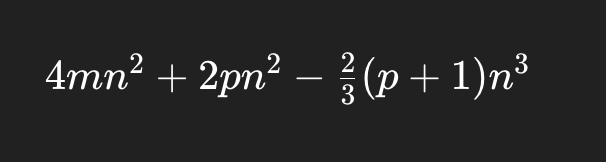



In [7]:
def indirect_tsqr_flops(m, n, p):
    """
    Estimate FLOPs for Indirect TSQR.

    Parameters:
    - m: Total number of rows in matrix A
    - n: Number of columns in matrix A (n << m)
    - p: Number of partitions (blocks)

    Returns:
    - Total estimated FLOPs
    """
    # Local QR per block (m/p × n): p × [2mn² - (2/3)n³]
    flops_local_qr = p * (2 * (m // p) * n**2 - (2 / 3) * n**3)

    # Global QR on stacked R (p × n): 2pn² - (2/3)n³
    flops_global_qr = 2 * p * n**2 - (2 / 3) * n**3

    # Matrix multiply: Q = A @ inv(R), A is (m×n), inv(R) is (n×n)
    flops_q_reconstruction = 2 * m * n**2

    total_flops = flops_local_qr + flops_global_qr + flops_q_reconstruction
    return total_flops

print(indirect_tsqr_flops(m=A.shape[0], n=A.shape[1], p=4))


414.0


## Direct TSQR

In [8]:
import dask.array as da
import numpy as np
from dask import delayed

# STEP 4: Direct TSQR using Dask (MapReduce-style)

def direct_tsqr(A):
    blocks = A.to_delayed().flatten()

    # Step 1: Map - compute local QR for each block
    local_qs = []
    local_rs = []

    for block in blocks:
        @delayed
        def local_qr(b):
            q, r = np.linalg.qr(b)
            return q, r
        q_r = local_qr(block)
        local_qs.append(delayed(lambda x: x[0])(q_r))
        local_rs.append(delayed(lambda x: x[1])(q_r))

    # Step 2: Reduce - stack R blocks and compute global QR
    R_stack = da.vstack([da.from_delayed(r, shape=(3, 3), dtype=float) for r in local_rs])
    R_stack_np = R_stack.compute()
    Q2, R_final = np.linalg.qr(R_stack_np)

    # Step 3: Multiply each local Q1[i] with corresponding Q2[i]
    # Since we had 3 blocks of 3x3 R matrices → Q2 is 9x3
    Q2_blocks = np.split(Q2, len(local_qs))  # 3 blocks

    final_qs = []
    for i in range(len(local_qs)):
        q1 = local_qs[i]
        q2 = Q2_blocks[i]
        @delayed
        def matmul(q1_block, q2_block):
            return q1_block @ q2_block
        final_qs.append(matmul(q1, q2))

    Q_final = da.vstack([da.from_delayed(q, shape=(4, 3), dtype=float) for q in final_qs])
    return Q_final, R_final

# Run the algorithm
Q_direct, R_direct = direct_tsqr(A)

# Output
print("Q (Direct TSQR):\n", Q_direct.compute())
print("R (Direct TSQR):\n", R_direct)



Q (Direct TSQR):
 [[ 0.17   0.034 -0.209]
 [ 0.522  0.049  0.028]
 [ 0.541 -0.241  0.088]
 [ 0.186  0.127  0.129]
 [ 0.083  0.549  0.532]
 [-0.193  0.299 -0.069]
 [-0.311  0.418 -0.402]
 [-0.077 -0.017  0.436]
 [-0.186 -0.025  0.362]
 [ 0.129  0.169  0.083]
 [-0.206 -0.527  0.004]
 [-0.362 -0.224  0.392]]
R (Direct TSQR):
 [[ 2.919 -0.124 -0.279]
 [ 0.    -3.468  0.109]
 [ 0.     0.    -3.313]]


In [9]:
def direct_tsqr_flops(m, n, p):
    """
    m = total rows of A
    n = number of columns of A
    p = number of blocks
    """
    # Local QR per block
    flop_qr_local = p * (2 * m//p * n**2 - (2/3) * n**3)

    # QR of stacked R (p * n rows, n cols)
    flop_qr_top = 2 * p * n * n**2 - (2/3) * n**3

    # Matmul A @ R^{-1}
    flop_q_final = 2 * m * n**2

    return flop_qr_local + flop_qr_top + flop_q_final


In [10]:
# Create a tall-and-skinny Dask array A
import dask.array as da

# Example: 12x3 matrix split into 4 row blocks
A = da.random.random((12, 3), chunks=(3, 3))

# Run Direct TSQR
Q_direct, R_direct = direct_tsqr(A)

# Trigger computation and show results
print("Q (Direct TSQR):\n", Q_direct.compute())
print("R (Direct TSQR):\n", R_direct)

flops_chol = direct_tsqr_flops(A.shape[0], A.shape[1], 4)
print("Total FLOPs (Direct TSQR):", int(flops_chol))


Q (Direct TSQR):
 [[ 0.088 -0.262  0.36 ]
 [ 0.092  0.047  0.105]
 [ 0.466 -0.112 -0.168]
 [ 0.445  0.432  0.21 ]
 [ 0.369 -0.188 -0.308]
 [ 0.111 -0.465  0.245]
 [ 0.079 -0.11   0.417]
 [ 0.228 -0.038  0.47 ]
 [ 0.145 -0.095 -0.015]
 [ 0.12  -0.498  0.102]
 [ 0.373  0.428  0.186]
 [ 0.433 -0.159 -0.439]]
R (Direct TSQR):
 [[ 2.062  1.646  1.244]
 [ 0.    -1.057 -0.85 ]
 [ 0.     0.     1.128]]
Total FLOPs (Direct TSQR): 558



### 🔢 Direct TSQR FLOPs Breakdown (for m = 12, n = 3, p = 4)

#### 1. Local QR per block

Each block has $\frac{m}{p} = \frac{12}{4} = 3$ rows and $n = 3$ columns.

$$
\text{FLOPs}_{\text{local}} = p \cdot \left(2 \cdot \frac{m}{p} \cdot n^2 - \frac{2}{3} n^3\right)
= 4 \cdot \left(2 \cdot 3 \cdot 9 - \frac{2}{3} \cdot 27\right)
= 4 \cdot (54 - 18)
= 4 \cdot 36 = \boxed{144}
$$

---

#### 2. QR of stacked $R_i$ (Top QR)

QR of stacked matrix $S^{(1)} \in \mathbb{R}^{(p \cdot n) \times n} = \mathbb{R}^{12 \times 3}$:

$$
\text{FLOPs}_{\text{top}} = 2 \cdot p \cdot n \cdot n^2 - \frac{2}{3} n^3
= 2 \cdot 4 \cdot 3 \cdot 9 - \frac{2}{3} \cdot 27
= 216 - 18 = \boxed{198}
$$

---

#### 3. Final multiplication $Q = A \cdot R^{-1}$

$$
\text{FLOPs}_{Q_{\text{final}}} = 2 \cdot m \cdot n^2
= 2 \cdot 12 \cdot 9 = \boxed{216}
$$

---

#### ✅ Total FLOPs

$$
\text{Total FLOPs} = 144 + 198 + 216 = \boxed{558}
$$


## Results

In [11]:
# STEP 6: Evaluation Functions

def reconstruction_error(A, Q, R):
    A_np = A.compute() if isinstance(A, da.Array) else A
    Q_np = Q.compute() if isinstance(Q, da.Array) else Q
    error = np.linalg.norm(A_np - Q_np @ R, ord='fro') / np.linalg.norm(R, ord='fro')
    return error

def orthogonality_error(Q):
    Q_np = Q.compute() if isinstance(Q, da.Array) else Q
    I = np.eye(Q_np.shape[1])
    error = np.linalg.norm(Q_np.T @ Q_np - I, ord='fro')
    return error


In [12]:
from colorama import Fore, Style, init
init(autoreset=True)

def getFLOPS(A):
    print(f"\n{Style.BRIGHT}{Fore.MAGENTA}🎯 FLOP Comparison\n")
    
    methods = []

    try:
        _, _, flops = cholesky_qr(A)
        methods.append((f"{Fore.CYAN}Cholesky QR", f"{Fore.GREEN}{flops:,}"))
    except Exception as e:
        methods.append((f"{Fore.CYAN}Cholesky QR", f"{Fore.RED}⚠️ {e}"))

    try:
        flops = householder_flops(A.shape[0], A.shape[1])
        methods.append((f"{Fore.CYAN}Householder QR", f"{Fore.GREEN}{flops:,}"))
    except Exception as e:
        methods.append((f"{Fore.CYAN}Householder QR", f"{Fore.RED}⚠️ {e}"))

    try:
        ind_flops = indirect_tsqr_flops(m=A.shape[0], n=A.shape[1], p=4)
        methods.append((f"{Fore.CYAN}Indirect TSQR", f"{Fore.GREEN}{ind_flops:,}"))
    except Exception as e:
        methods.append((f"{Fore.CYAN}Indirect TSQR", f"{Fore.RED}⚠️ {e}"))

    try:
        flops = direct_tsqr_flops(m=A.shape[0], n=A.shape[1], p=4)
        methods.append((f"{Fore.CYAN}Direct TSQR", f"{Fore.GREEN}{flops:,}"))
    except Exception as e:
        methods.append((f"{Fore.CYAN}Direct TSQR", f"{Fore.RED}⚠️ {e}"))

    for method, value in methods:
        print(f"{method:<25}: {value}")

def getErrors(A_test):
    print(f"\n{Style.BRIGHT}{Fore.MAGENTA}🎯 QR Error Metrics\n")

    results = []
    error_flag = False

    try:
        Q_chol, R_chol, _ = cholesky_qr(A_test)
    except Exception as e:
        if not error_flag:
            print(f"{Fore.RED}⚠️ Error in Cholesky QR: {e}")
            error_flag = True
        Q_chol, R_chol = None, None

    try:
        Q_indir, R_indir = indirect_tsqr(A_test)
    except Exception as e:
        if not error_flag:
            print(f"{Fore.RED}⚠️ Error in Indirect TSQR: {e}")
            error_flag = True
        Q_indir, R_indir = None, None

    try:
        Q_direct, R_direct = direct_tsqr(A_test)
        Q_direct = Q_direct.compute()
    except Exception as e:
        if not error_flag:
            print(f"{Fore.RED}⚠️ Error in Direct TSQR: {e}")
            error_flag = True
        Q_direct, R_direct = None, None

    try:
        Q_house, R_house = householder_qr(A_test)
    except Exception as e:
        if not error_flag:
            print(f"{Fore.RED}⚠️ Error in Householder QR: {e}")
            error_flag = True
        Q_house, R_house = None, None

    methods = [
        ("Cholesky QR", Q_chol, R_chol),
        ("Indirect TSQR", Q_indir, R_indir),
        ("Direct TSQR", Q_direct, R_direct),
        ("Householder QR", Q_house, R_house)
    ]

    for name, Q, R in methods:
        try:
            rec_err = reconstruction_error(A_test, Q, R)
            ortho_err = orthogonality_error(Q)
            results.append((f"{Fore.CYAN}{name}", f"{Fore.GREEN}{rec_err:.2e}", f"{Fore.GREEN}{ortho_err:.2e}"))
        except Exception as e:
            results.append((f"{Fore.CYAN}{name}", f"{Fore.RED}⚠️ Error", f"{Fore.RED}⚠️ Error"))

    print(f"{Style.BRIGHT}{Fore.YELLOW}{'Method':<20}{'Reconstruction Error':>25}{'Orthogonality Error':>25}")
    for name, rec, ortho in results:
        print(f"{name:<20}{rec:>25}{ortho:>25}")


In [13]:
A_bad = np.array([
    [1.0, 1.0, 1.0],
    [2.0, 2.0, 2.0],
    [3.0, 3.0, 3.00000001],
    [4.0, 4.0, 4.0],
    [5.0, 5.0, 5.00000001],
    [6.0, 6.0, 6.0],
    [7.0, 7.0, 7.00000001],
    [8.0, 8.0, 8.0],
    [9.0, 9.0, 9.00000001],
    [10.0, 10.0, 10.0],
    [11.0, 11.0, 11.00000001],
    [12.0, 12.0, 12.0]
])
A_bad = da.from_array(A_bad, chunks=(4, 3))


In [14]:
#randomly create a positive definite matrix of shape m,n
import numpy as np

def create_positive_definite_matrix(m, n):
    # Create a random matrix
    A = np.random.rand(m, n)

    # Compute A.T @ A, which is guaranteed to be positive semi-definite
    positive_semi_definite_matrix = A.T @ A

    # Add a small multiple of the identity matrix to ensure positive definiteness
    epsilon = 1e-6  # A small positive value
    positive_definite_matrix = positive_semi_definite_matrix + epsilon * np.eye(n)

    return positive_definite_matrix

# Example usage: create a 3x3 positive definite matrix
m = 12
n = 3
positive_definite_matrix = create_positive_definite_matrix(m, n)
positive_definite_matrix

A_good = positive_definite_matrix
A_good = da.from_array(A_good, chunks=(4, 3))

In [21]:
def generate_tall_high_kappa(n=12, d=3, kappa=1e8):
    """
    Generate a tall (n x d) matrix with high condition number.
    Not necessarily PSD, but good for TSQR testing.
    """
    # Step 1: Generate orthonormal matrix V (d x d)
    V, _ = np.linalg.qr(np.random.randn(d, d))
    
    # Step 2: Construct diagonal with spread eigenvalues
    S = np.diag(np.geomspace(kappa, 1, d))  # High condition number

    # Step 3: Build A = U S Vᵀ where U is tall (n x d), orthonormal-ish
    U, _ = np.linalg.qr(np.random.randn(n, d))
    A = U @ S @ V.T
    return A


A_high_kappa = generate_tall_high_kappa(n=12*10**3, d=3, kappa=1e8)
A_high_kappa = da.from_array(A_high_kappa, chunks=(4, 3))


In [22]:
getErrors(A_bad)


🎯 QR Error Metrics

⚠️ Error in Cholesky QR: Matrix is not positive definite
Method                   Reconstruction Error      Orthogonality Error
Cholesky QR                ⚠️ Error            ⚠️ Error
Indirect TSQR              5.58e-11            3.17e+00
Direct TSQR                6.78e-16            1.06e-15
Householder QR             3.33e-16            4.75e-16


In [23]:
getErrors(A_good)


🎯 QR Error Metrics

Method                   Reconstruction Error      Orthogonality Error
Cholesky QR                1.37e-16            4.59e-15
Indirect TSQR              1.89e-16            9.06e-16
Direct TSQR                2.03e-16            2.69e-16
Householder QR             2.03e-16            2.69e-16


In [24]:
getErrors(A_high_kappa)


🎯 QR Error Metrics

Method                   Reconstruction Error      Orthogonality Error
Cholesky QR                6.78e-17            7.98e-01
Indirect TSQR              6.96e-17            2.94e-08
Direct TSQR                4.97e-16            3.14e-15
Householder QR             1.82e-15            3.93e-15


In [25]:
getFLOPS(A_high_kappa)


🎯 FLOP Comparison

Cholesky QR         : 432,018.0
Householder QR      : 215,982
Indirect TSQR       : 431,982.0
Direct TSQR         : 432,126.0
